1. データの読み込み

In [1]:
import math
import random
import time
import warnings
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import os
import transformers as T
from pathlib import Path
from sklearn.metrics import fbeta_score
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [2]:
warnings.filterwarnings("ignore")

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
def seed_torch(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed = 471
seed_torch(seed)

In [5]:
DATA_DIR = './dataset/data1'

In [6]:
train = pd.read_csv(DATA_DIR  +"/train.csv", index_col=0).fillna(" ")
test = pd.read_csv(DATA_DIR + "/test.csv", index_col=0).fillna(" ")


In [7]:
train.head()

,title,abstract,judgement
id,,,
0,One-year age changes in MRI brain volumes in o...,Longitudinal studies indicate that declines in...,0
1,Supportive CSF biomarker evidence to enhance t...,The present study was undertaken to validate t...,0
2,Occurrence of basal ganglia germ cell tumors w...,Objective: To report a case series in which ba...,0
3,New developments in diagnosis and therapy of C...,The etiology and pathogenesis of idiopathic ch...,0
4,Prolonged shedding of SARS-CoV-2 in an elderly...,,0


In [8]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()

In [9]:
title_list = train['title'].values.tolist()
vect.fit(title_list)
title_token_oh = vect.transform(title_list)
title_token_oh = title_token_oh.toarray()

In [10]:
abstract_list = train['abstract'].values.tolist()
vect.fit(abstract_list)
abstract_token_oh = vect.transform(abstract_list)
abstract_token_oh = abstract_token_oh.toarray()

In [11]:
def append_len(df):
    len_title = df.title.apply(len)
    len_abstract = df.abstract.apply(len)
    df["len_title"] = len_title
    df["len_abstract"] = len_abstract
    return df
train = append_len(train)
test = append_len(test)

<AxesSubplot:xlabel='len_title', ylabel='Density'>

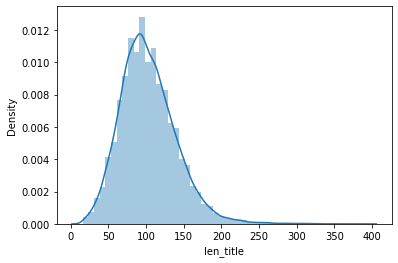

In [12]:
import seaborn as sns
sns.distplot(train['len_title'])

<AxesSubplot:xlabel='len_abstract', ylabel='Density'>

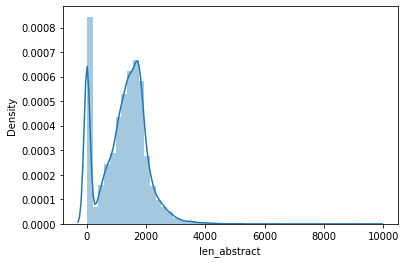

In [13]:
import seaborn as sns
sns.distplot(train['len_abstract'])

<AxesSubplot:xlabel='judgement', ylabel='len_title'>

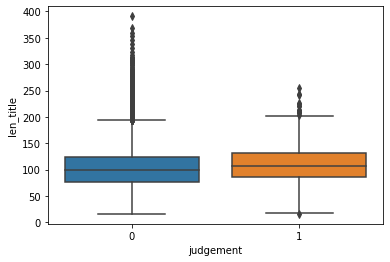

In [14]:
sns.boxplot(x=train.judgement, y=train['len_title'])

<AxesSubplot:xlabel='judgement', ylabel='len_title'>

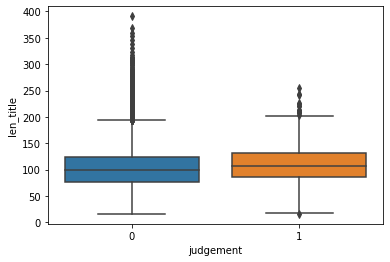

In [15]:
sns.boxplot(x=train.judgement, y=train['len_title'])

Text(0.5, 0, 'Message Length')

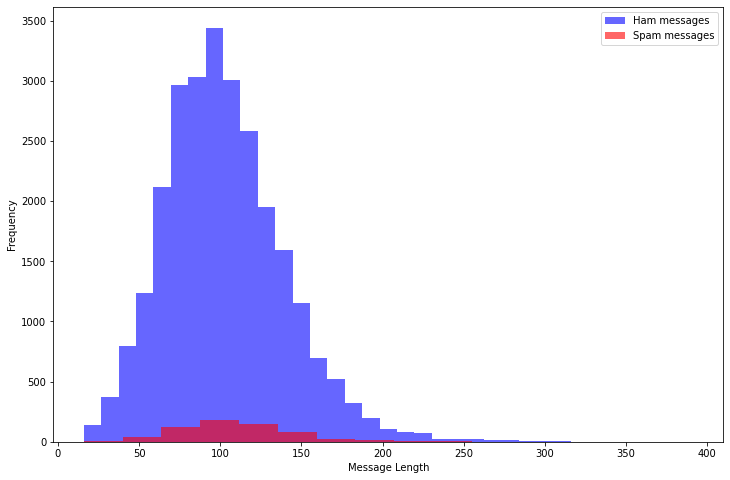

In [16]:
plt.figure(figsize=(12, 8))

train[train.judgement==0].len_title.plot(bins=35, kind='hist', color='blue', 
                                       label='Ham messages', alpha=0.6)
train[train.judgement==1].len_title.plot(kind='hist', color='red', 
                                       label='Spam messages', alpha=0.6)
plt.legend()
plt.xlabel("Message Length")

Text(0.5, 0, 'Message Length')

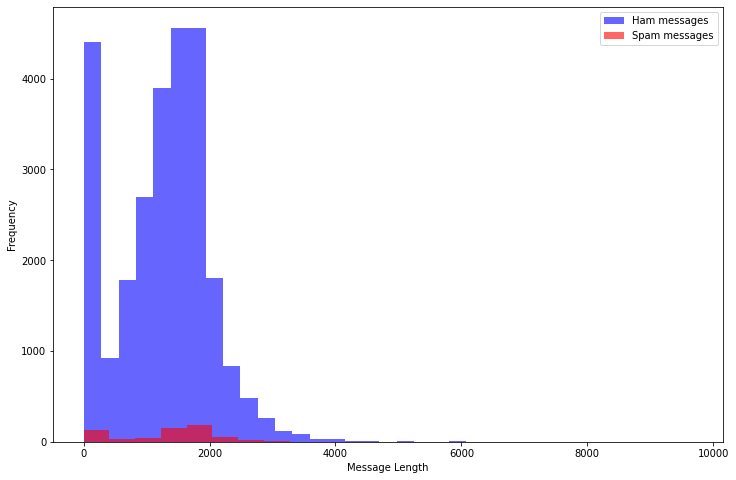

In [17]:
plt.figure(figsize=(12, 8))

train[train.judgement==0].len_abstract.plot(bins=35, kind='hist', color='blue', 
                                       label='Ham messages', alpha=0.6)
train[train.judgement==1].len_abstract.plot(kind='hist', color='red', 
                                       label='Spam messages', alpha=0.6)
plt.legend()
plt.xlabel("Message Length")

In [18]:
import string
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

In [19]:
def text_process(mess):
    STOPWORDS = stopwords.words('english') + ['u', 'ü', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure']
    a = ''.join(map(str, list(range(10))))
    nopunc = [char for char in mess if char not in string.punctuation +a]
    nopunc = ''.join(nopunc)
    return ' '.join([word.lower() for word in nopunc.split() if word.lower() not in STOPWORDS])

In [20]:
train['title_token'] = train.title.apply(text_process)
train['abstract_token'] = train.abstract.apply(text_process)
test['title_token'] = test.title.apply(text_process)
test['abstract_token'] = test.abstract.apply(text_process)

In [31]:
vectorizer = CountVectorizer()
vectorizer.fit(pd.concat([train['title_token'], test['title_token']], axis=0).tolist())
title_list = vectorizer.get_feature_names()
X_title_train = vectorizer.transform(train['title_token']).toarray()
X_title_test = vectorizer.transform(test['title_token']).toarray()

In [32]:
vectorizer = CountVectorizer()
vectorizer.fit(pd.concat([train['abstract_token'], test['abstract_token']], axis=0).tolist())
abstract_list = vectorizer.get_feature_names()
X_abstract_train = vectorizer.transform(train['abstract_token']).toarray()
X_abstract_test = vectorizer.transform(test['abstract_token']).toarray()

In [33]:
X_abstract_train.shape

(27145, 141376)

In [34]:
# Santandarのデータには適用できないので、簡単な紹介のみ
from operator import itemgetter
from sklearn.feature_selection import chi2
# fisher score
fscore = chi2(X_title_train, train.judgement)[0]

In [35]:
#とりあえず次元が多すぎるので上位500のみ使用する
fscore = chi2(X_title_train, train.judgement)[0]
fscore = np.array(fscore)
idx = np.argsort(-fscore)[:500]
X_title_500_train = X_title_train[:, idx]
X_title_500_test = X_title_test[:, idx]
title_list_500 = np.array(title_list)[idx]

In [36]:
#とりあえず次元が多すぎるので上位500のみ使用する
fscore = chi2(X_abstract_train, train.judgement)[0]
fscore = np.array(fscore)
idx = np.argsort(-fscore)[:500]
X_abstract_500_train = X_abstract_train[:, idx]
X_abstract_500_test = X_abstract_test[:, idx]
abstract_list_500 = np.array(abstract_list)[idx]

In [37]:
X_chi2_train = np.concatenate([X_title_500_train, X_abstract_500_train], axis = 1)
X_chi2_test = np.concatenate([X_title_500_test, X_abstract_500_test], axis = 1)

In [38]:
columns_title = list(map(lambda x:f"title_count_{x}", title_list_500))
columns_abstract = list(map( lambda x:f"abstract_count_{x}", abstract_list_500))
train.loc[:, columns_title + columns_abstract] = X_chi2_train
test.loc[:, columns_title + columns_abstract] = X_chi2_test

In [50]:
#保存先のディレクトリ作成
save_dir = "./dataset/data3"
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
train.to_csv(os.path.join(save_dir, 'train.csv'))
test.to_csv(os.path.join(save_dir, 'test.csv'))